In [72]:
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert
from pygimli.viewer.pv import drawStreamLines, drawSlice

In [73]:
eldist = 0.023
eldia = 0.0075
size2 = 0.05
plc = mt.createWorld(start=[-size2, -size2, -size2], end=[size2+3*eldist, size2, 0], area=2e-7)
for i in range(4):
    pad = mt.createFacet(mt.createCircle(pos=[i*eldist, 0, 0], radius=eldia/2, nSegments=16, isHole=True)) 
    plc.copyBoundary(pad.boundary(0))
    plc.createBoundary(plc.nodes([plc.createNode(n.pos()).id() for n in pad.nodes() ]), marker=-10000-i) # -10000-1)

for x in np.arange(0, 3*eldist, 0.0003):
    plc.createNode([x, 0, -0.0003])

mesh = mt.createMesh(plc, quality=1.15)
print(mesh)
mesh.node(0).setMarker(-999)
mesh.node(1).setMarker(-1000)
print(np.unique(mesh.boundaryMarkers()))
pg.show(mesh, showMesh=True, markers=True, backend="trame")

16/11/23 - 13:25:45 - pyGIMLi - WARNING - Given data fits neither cell count nor node count:
16/11/23 - 13:25:45 - pyGIMLi - WARNING - 53044 vs. 0 vs. 2328


Mesh: Nodes: 5369 Cells: 25359 Boundaries: 53044
[-10003 -10002 -10001 -10000     -2     -1      0]


Widget(value="<iframe src='http://localhost:59307/index.html?ui=P_0x214dac042b0_44&reconnect=auto' style='widt…

(<pyvista.plotting.plotting.Plotter at 0x214dac042b0>, None)

In [74]:
shm = pg.DataContainerERT()
for i in range(4):
    shm.createSensor([i*eldist, 0, 0])

shm.addFourPointData(0, 3, 1, 2)
print(shm)
shm["k"] = 1.  # set to 1 so that it can be computed

Data: Sensors: 4 data: 1, nonzero entries: ['a', 'b', 'm', 'n', 'valid']


The geometric factor is the ratio of the resistivity and the computed resistance.

In [75]:
shm["k"] = 1. / ert.simulate(mesh, shm, res=1.0, sr=False, verbose=True, returnArray=True)

In [76]:
fop = ert.ERTModelling(sr=False, verbose=True)
fop.setData(shm)
fop.setMesh(mesh)
fop._core.setContactImpedances(np.ones(shm.sensorCount())*1e-12)
fop._core.createRefinedForwardMesh(True, False)
model = np.ones(mesh.cellCount()) * 100
res = fop.response(model)
print(res)  # should be 100
fop.createJacobian(model)
sens = fop.jacobian()[0]

16/11/23 - 13:25:59 - pyGIMLi - INFO - Found 1 regions.
16/11/23 - 13:26:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/11/23 - 13:26:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/11/23 - 13:26:08 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 38422 Cells: 202872 Boundaries: 212176


1 [99.7790008522919]


In [77]:
ssens = sens / mesh.cellSizes()
mesh["sens"] = ssens
mesh["normsens"] = pg.utils.logDropTol(ssens, 1e1)
mesh["symsens"] = pg.core.math.symlog(ssens, 10)
mesh["asens"] = np.abs(mesh["sens"])
sli = mt.extract2dSlice(mesh)

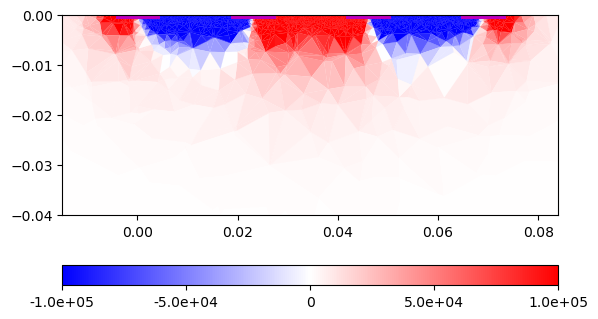

In [78]:
mm = 1e5
# mm = 10
ax, cb = pg.show(sli, "sens", cMin=-mm, cMax=mm, cMap="bwr")
ax.set_xlim(-0.015, 3*eldist+0.015)
ax.set_ylim(-0.04, 0)
for i in range(4):
    ax.plot([i*eldist-eldia/2, i*eldist+eldia/2], [0, 0], "m-", lw=5)

In [83]:
ax, _ = pg.show(mesh, "sens", alpha=0.3, hold=True, backend="trame", cMap="bwr", cMin=-1e4, cMax=1e4, 
                filter={"threshold": dict(scalars="asens", value=1e4)})
ax.show()

Widget(value="<iframe src='http://localhost:59307/index.html?ui=P_0x211b84fc0d0_47&reconnect=auto' style='widt…

In [80]:
dsffsdf

NameError: name 'dsffsdf' is not defined

In [ ]:
u = ert.simulate(mesh, shm, res=1.0, sr=False, verbose=True, returnFields=True)
print(u.shape)

(4, 12286)


In [ ]:
uAB = u[0] - u[3]
logU = pg.core.math.symlog(uAB, 0.1)
print(max(logU))

2.9021601789246265


In [ ]:
j = -pg.solver.grad(mesh, uAB)  # actually times sigma=1S/m

In [ ]:
# mesh.clearData()
# pvmesh = pg.viewer.pv.pgMesh2pvMesh(mesh, j)
# print(pvmesh)

UnstructuredGrid (0x27e57a24820)
  N Cells:    58858
  N Points:   12286
  X Bounds:   -5.000e-02, 1.190e-01
  Y Bounds:   -5.000e-02, 5.000e-02
  Z Bounds:   -5.000e-02, 0.000e+00
  N Arrays:   2



In [ ]:
ax, _ = pg.show(mesh, "sens", alpha=0.3, hold=True, backend="trame", cMap="bwr", cMin=-1e4, cMax=1e4,
                filter={"threshold": dict(scalars="asens", value=1e4)})
# drawStreamLines(ax, mesh, uAB, source_center=[0, 0, 0], source_radius=eldia/2, radius=0.0002, initial_step_length=0.01, min_step_length=0.0001)
# drawStreamLines(ax, mesh, uAB, source_center=[3*eldist, 0, 0], source_radius=eldia/2, radius=0.0002, initial_step_length=0.002, min_step_length=0.0001)
# drawSlice(ax, mesh, normal=[0,1,0], data=uAB, cmap="bwr", cMin=-4, cMax=4, label="Potential")
ax.show()

Widget(value="<iframe src='http://localhost:59307/index.html?ui=P_0x2152275fe20_43&reconnect=auto' style='widt…

In [ ]:
# mesh.swapCoordinates(0, 2)
# mesh.scale([-1, 1, 1])
# ax, _ = pg.show(mesh, alpha=0.3, hold=True, backend="trame")
# drawStreamLines(ax, mesh, uAB, source_center=[0, 0, 0], source_radius=eldia/2, radius=0.0001)
# drawSlice(ax, mesh, normal=[0,1,0], data=uAB, cmap="bwr", cMin=-4, cMax=4, label="Potential")
# ax.show()

In [87]:
4.25**(-1/1.3)

0.32856696787048595